<a href="https://colab.research.google.com/github/pedro-pauletti/deeplearning-pytorch/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Transforms

In [23]:
!pip3 install torch torchvision

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [29]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(0),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #Data Augmentation only on the training dataset
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
training_dataset

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()  # Move to CPU before converting to NumPy array
    image = image.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    image = image * 0.5 + 0.5  # Denormalize the image
    return image


In [31]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

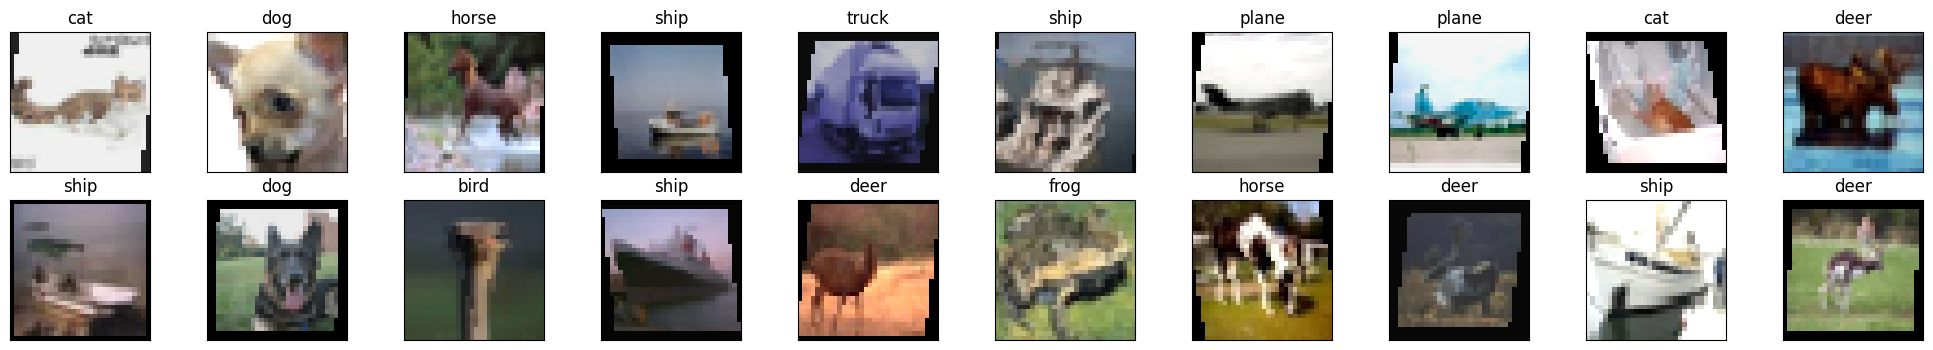

In [32]:
dataiter = iter(training_loader)
images, labels = next(dataiter)  # Fetch the next batch using the next() function

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

### Neural Network Implementation

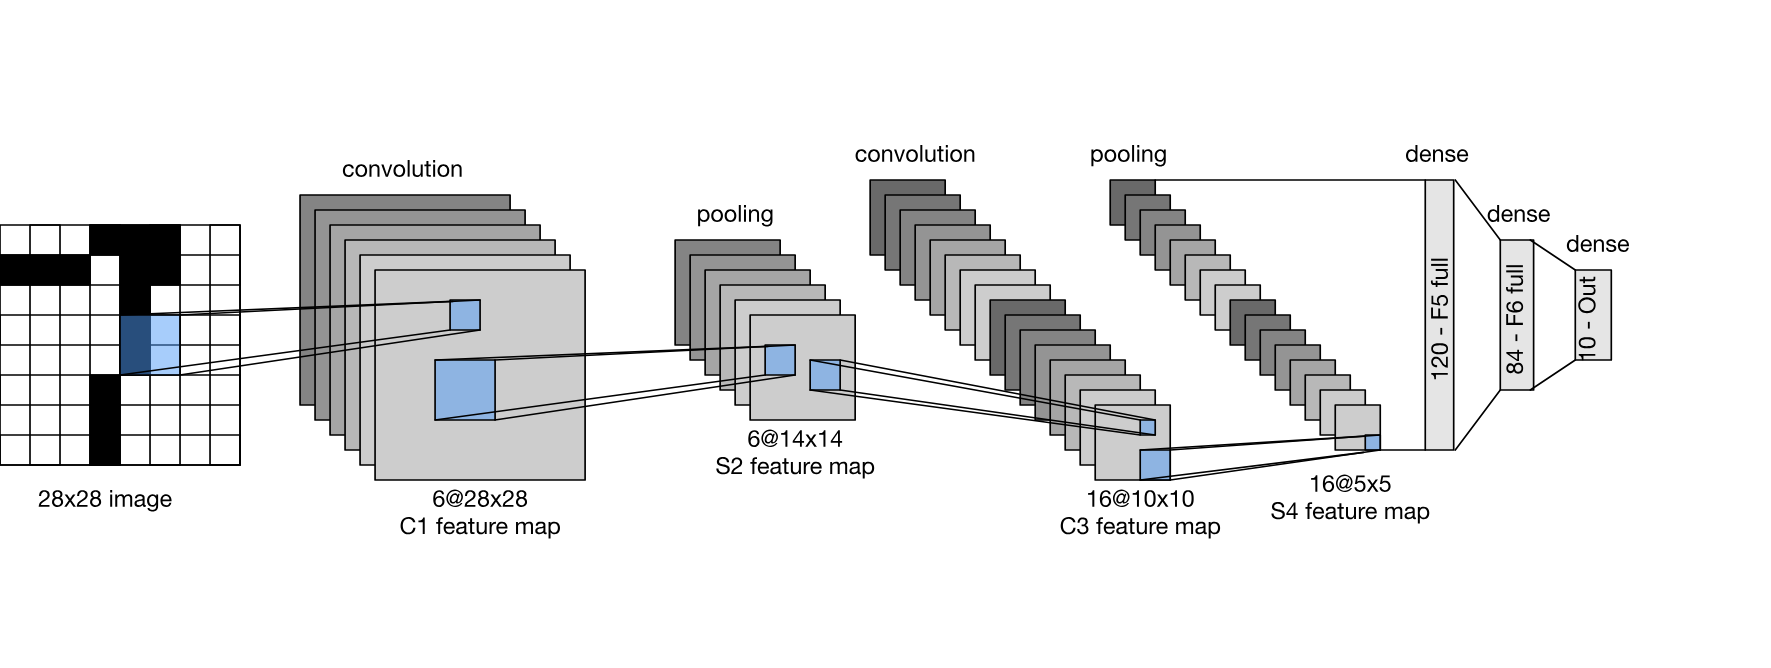

In [33]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [34]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [36]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float() / len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)


    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: ', (e+1))
    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
training loss: 0.0168, accuracy: 0.3831
validation loss: 0.0138, validation accuracy: 0.4972
epoch:  2
training loss: 0.0136, accuracy: 0.5092
validation loss: 0.0123, validation accuracy: 0.5599
epoch:  3
training loss: 0.0122, accuracy: 0.5661
validation loss: 0.0112, validation accuracy: 0.6019
epoch:  4
training loss: 0.0112, accuracy: 0.6008
validation loss: 0.0105, validation accuracy: 0.6315
epoch:  5
training loss: 0.0106, accuracy: 0.6263
validation loss: 0.0097, validation accuracy: 0.6617
epoch:  6
training loss: 0.0101, accuracy: 0.6437
validation loss: 0.0094, validation accuracy: 0.6732
epoch:  7
training loss: 0.0098, accuracy: 0.6571
validation loss: 0.0092, validation accuracy: 0.6814
epoch:  8
training loss: 0.0093, accuracy: 0.6724
validation loss: 0.0088, validation accuracy: 0.6960
epoch:  9
training loss: 0.0091, accuracy: 0.6858
validation loss: 0.0085, validation accuracy: 0.7004
epoch:  10
training loss: 0.0089, accuracy: 0.6910
validation loss: 0.008

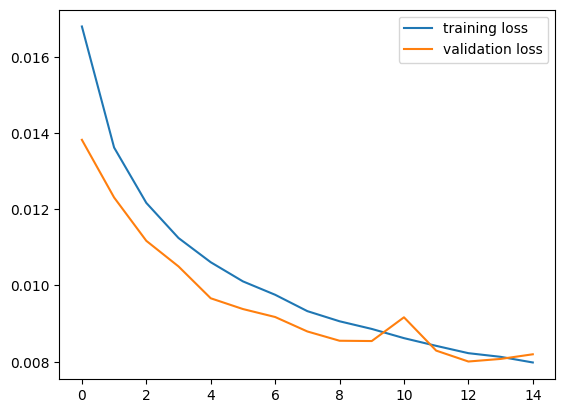

In [37]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

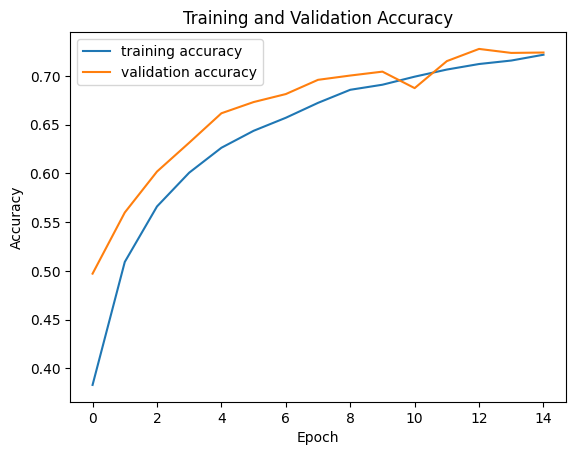

In [38]:
# Convert the tensors to CPU (host) before plotting
running_corrects_history_cpu = [t.item() for t in running_corrects_history]
val_running_corrects_history_cpu = [t.item() for t in val_running_corrects_history]

plt.plot(running_corrects_history_cpu, label='training accuracy')
plt.plot(val_running_corrects_history_cpu, label='validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

### Final Tests

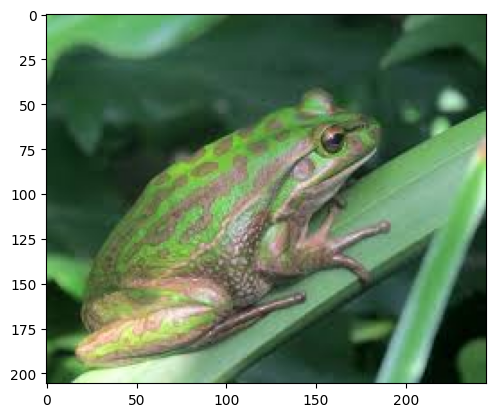

In [39]:
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQR8KjnnwvSA7KmtfxkvcxF9ZPQtFAUnOXh2w&usqp=CAU'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

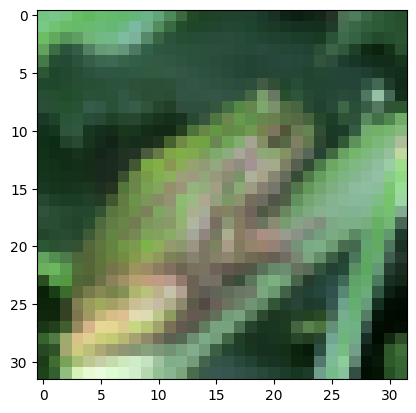

In [40]:
img = transform(img)
plt.imshow(im_convert(img))

In [41]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


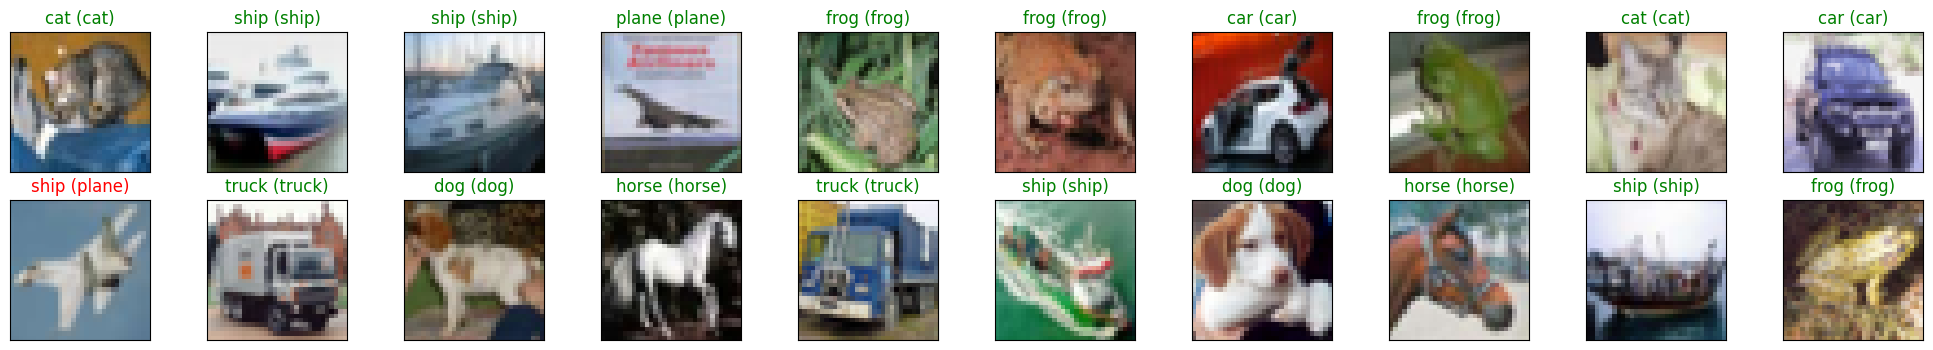

In [43]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)


fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),color = ("green" if preds[idx]==labels[idx] else "red") )